# **Project 3: Breast Cancer Detection Using Data from Microwave Sensors  **

In [32]:
#libraries importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score, f1_score
from pycaret.classification import setup, compare_models, tune_model, evaluate_model

In [33]:
# Loading the dataset
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Sensor Data.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Part 1: Data preprocessing**

In [34]:
# 1- Checking for nulls
print('Null values ->')
print(data.isnull().sum())

Null values ->
Freq [GHz]        0
S12 Mag           0
S13 Mag           0
S14 Mag           0
S23 Mag           0
S24 Mag           0
S34 Mag           0
S12 Phase         0
S13 Phase         0
S14 Phase         0
S23 Phase         0
S24 Phase         0
S34 Phase         0
S11 Mag           0
S22 Mag           0
S33 Mag           0
S44 Mag           0
S11 Phase         0
S22 Phase         0
S33 Phase         0
S44 Phase         0
Unnamed: 21    2002
Size              0
dtype: int64


In [35]:
# Only Column 21 is empty (null) so it will be dropped
data = data.drop(columns=["Unnamed: 21"], errors='ignore')

In [36]:
# 2- Checking and removing duplicates
print('duplicate values -> {}'.format(data.duplicated().sum()))
data = data.drop_duplicates()

duplicate values -> 0


In [37]:
# 3- Reclassifying target variable 'Size': 20 -> 1 (tumor present), others -> 0 (no tumor)
data["Size"] = data["Size"].apply(lambda x: 1 if x == 20 else 0)

In [38]:
# 4- Removing outliers using the IQR method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
# Output the results
print(f"Original dataset shape: {data.shape}")

Original dataset shape: (1297, 22)


In [39]:
# 5- Separating the dataset to features and target
features = data.drop(columns=["Size"])
target = data["Size"]

In [40]:
# 6- Normalizing the feature columns using MinMax method
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

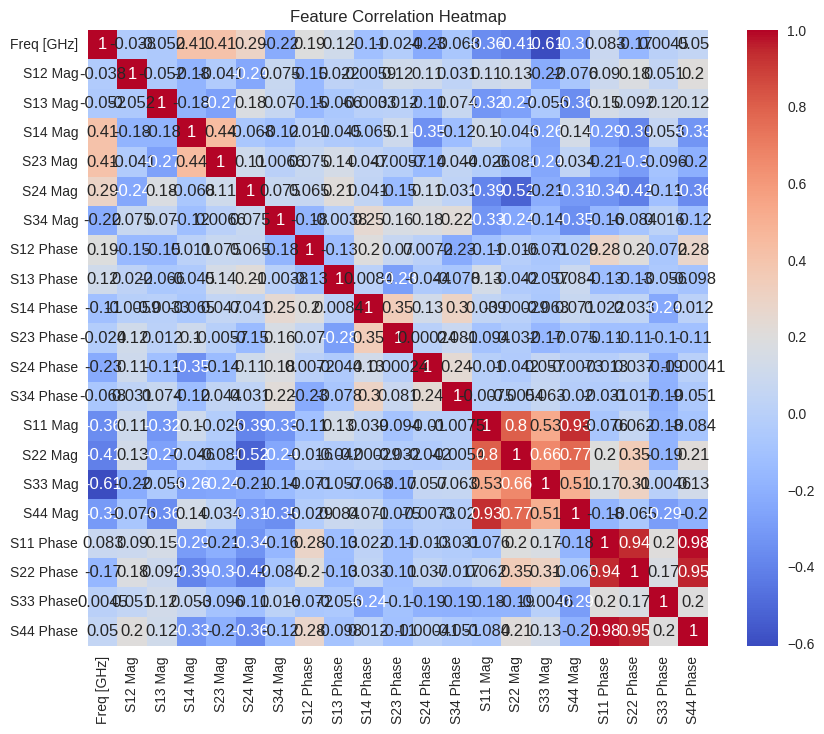

In [41]:
# 7- Features selection (correlation threshold > 0.1)
#the correlation between each feature and the target
correlation_matrix = pd.DataFrame(features_normalized, columns=features.columns).corrwith(target)
# Selectiing features with a significant relationship to the target
selected_features = correlation_matrix[correlation_matrix.abs() > 0.1].index
features_selected = pd.DataFrame(features_normalized, columns=features.columns)[selected_features]

# Display the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(features_normalized, columns=features.columns).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

**Part 2: Neural Network model**

In [42]:
# 1- Spliting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_selected, target, test_size=0.2, random_state=42)

**The model consists of an input layer with 128 neurons and a hidden layer with 64 neurons and an output layer with only one output as required to classify breast cancer based on tumor size (20 mm or no tumor). The input and hidden layers use the ReLU as an activation function and the output layer uses the Sigmoid activation function.**

In [43]:
# 2- The Neural Network model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'), # input layer
    Dense(64, activation='relu'), # hidden layer
    Dense(1, activation='sigmoid') # output layer
])

# optimizer and loss function
# Optimizer: Stochastic Gradient Descent (SGD), Learning Rate: 10^−3
optimizer = SGD(learning_rate=1e-3)
# Loss Function: Binary Cross Entropy
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
# 3- Training the model
predictions = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5094 - loss: 0.6921 - val_accuracy: 0.5673 - val_loss: 0.6830
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5431 - loss: 0.6875 - val_accuracy: 0.5817 - val_loss: 0.6821
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5363 - loss: 0.6883 - val_accuracy: 0.6010 - val_loss: 0.6811
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5462 - loss: 0.6888 - val_accuracy: 0.6250 - val_loss: 0.6802
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5953 - loss: 0.6837 - val_accuracy: 0.6490 - val_loss: 0.6792
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5812 - loss: 0.6858 - val_accuracy: 0.6635 - val_loss: 0.6783
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6305 - loss: 0.6802 - val_accuracy: 0.6683 - val_loss: 0.6773
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6243 - loss: 0.6823 - val_accuracy: 0.6731 -

In [45]:
# 4- Evaluating the model
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.9884615384615385
F1 Score: 0.9884169884169884


**The model achieves an accuracy of 98.85% and an F1 score of 98.84%. These metrics indicate that the model correctly predicts the tumor size for the vast majority of cases and handles both false positives and false negatives well.**

In [46]:
# 5- Experimentation with PyCaret Library

# Combining selected features and target into a single DataFrame for PyCaret
pycaret_data = pd.DataFrame(features_selected)
pycaret_data['Size'] = target.reset_index(drop=True)

# Initializing PyCaret
clf_setup = setup(data=pycaret_data, target='Size', verbose=False)

# Compare models
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.7040
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0320
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2470
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0530
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3450
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2140
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0710
ridge,Ridge Classifier,0.9989,1.0000,0.9978,1.0000,0.9989,0.9978,0.9978,0.0350
lightgbm,Light Gradient Boosting Machine,0.9989,1.0000,0.9977,1.0000,0.9989,0.9978,0.9978,0.4690
qda,Quadratic Discriminant Analysis,0.9978,1.0000,1.0000,0.9957,0.9978,0.9956,0.9957,0.0330


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [47]:
print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=6020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


**Pycaret choose the Logistic Regression as the best model for the Breast Cancer dataset**

**Comments on Pycaret library**

Pycaret simplified many steps and saved much time as a whole project might be made in minutes.

It saved time consumed in preprocessing tasks such as handling missing values, normalizing data, and encoding categorical variables are handled automatically during the setup() phase.

It also trains and evaluates machine learning models in a single line of code using compare_models() function, This helps a lot in identifying the best model.

It provides hyperparameter tuning using techniques which improves the model's performance.

The model performane is visualized and analyzed using evaluate_model() function.


In [ ]:
pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
   ━━━